In [240]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from perspective import psp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [176]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


**Notice: Unfortunately, due to sickness and multiple commitments, I fell behind on my PSET this week.**

I have completed Problem 1 and parts of Problem 3. Thank you for your understanding.


# Assignment 2

Due: 26th Sept, 11:59pm

# Problem 1: Spam, wonderful spam!

The dataset consists of a collection of 57 features relating to about 4600 emails and a label of whether or not the email is considered spam. You have a training set containing about 70% of the data and a test set containing about 30% of the data. Your job is to build effective spam classification rules using the predictors.

### A Note about Features

The column names (in the first row of each .csv file) are fairly self-explanatory.

* Some variables are named `word_freq_(word)`, which suggests a calculation of the frequency of how many times a specific word appears in the email, expressed as a percentage of total words in the email multiplied by 100.

* Some variables are named `char_freq_(number)`, which suggests a count of the frequency of the specific ensuing character, expressed as a percentage of total characters in the email multiplied by 100. Note, these characters are not valid column names in R, but you can view them in the raw .csv file. 

* Some variables are named `capital_run_length_(number)` which suggests some information about the average (or maximum length of, or total) consecutive capital letters in the email.

* `spam`: This is the response variable, 0 = not spam, 1 = spam.

### Missing Values

Unfortunately, the `capital_run_length_average` variable is corrupted and as a result, contains a fair number of missing values. These show up as `NaN` (the default way of representing missing values in Python.)

## Part a

Use $k$-nearest neighbors regression with $k=15$ to **impute** the missing values in the `capital_run_length_average` column using the other predictors after standardizing (i.e. rescaling) them. You may use a function such as <i>KNeighborsRegressor</i>  from the package <i>sklearn.neighbors</i> that performs $k$-nearest neighbors regression. There is no penalty for using a built-in function.

When you are done with this part, you should have no more NaN's in the `capital_run_length_average` column in either the training or the test set. To keep the training and test sets separate, you will need to build two models for imputing: one that is trained on, and imputes for, the training set, and another that is trained on, and imputes for, the test set. Make sure you show all of your work. (You may find the function <i>np.isnan()</i> useful for this problem.)

In [177]:
# my notes
# regression model: codomain of model is a continuous space, e.g. ℝ
# classification model: codomain of model is a discrete space, e.g. {0,1}

In [178]:
train = pd.read_csv("spam_train.csv")
test = pd.read_csv("spam_test.csv")

### Scaling

In [179]:
sc = StandardScaler()

In [180]:
def scaleAllColumnsExceptCRLA(df, sc, fit_type):
    # drop the column that remains unscaled
    CRLA_column = df[["capital_run_length_average"]]
    # scale the rest
    df = df.drop(columns="capital_run_length_average")
    if fit_type == "fit_transform":
        scaled_columns = sc.fit_transform(df)
    else:
        scaled_columns = sc.transform(df)
    # create new dataframe with scaled columns
    df = pd.DataFrame(scaled_columns, index=df.index, columns=df.columns)
    # concatenate and return
    return pd.concat([CRLA_column, df], axis=1)

In [181]:
train_scaled = scaleAllColumnsExceptCRLA(train, sc, "fit_transform")
test_scaled = scaleAllColumnsExceptCRLA(test, sc, "fit_transform")

### Fit KNR to non-NaN frames

In [182]:
from sklearn.neighbors import KNeighborsRegressor as knr

In [183]:
def fitKNRToData(notNaNData):
    regressor = knr(n_neighbors=15)
    X = notNaNData.drop(columns="capital_run_length_average")
    y = notNaNData["capital_run_length_average"]
    regressor.fit(X, y)
    return regressor 

In [184]:
def createPredictionsFromRegressor(regressor, NaNData):
    predictions = regressor.predict(NaNData.drop(columns="capital_run_length_average"))
    return predictions

In [185]:
def combinePredictionsWithNaNData(predictions, NaNData):
    NaNData = NaNData.drop(columns="capital_run_length_average")
    NaNData["capital_run_length_average"] = predictions
    return NaNData

In [186]:
def imputePipeline(df):
    # split into NaN and non-NaN rows
    not_nan_data = df.dropna()
    nan_data = df[np.isnan(df.capital_run_length_average)]
                  
    # fit KNR to non-NaN rows
    regressor = fitKNRToData(not_nan_data)
    
    # make predictions
    predictions = createPredictionsFromRegressor(regressor, nan_data)
    
    # add in to the previously NaN data
    imputed = combinePredictionsWithNaNData(predictions, nan_data)
    
    # sort imputed and non_nan
    imputed = imputed.reindex(sorted(imputed.columns), axis=1)
    not_nan_data = not_nan_data.reindex(sorted(not_nan_data.columns), axis=1)
    
    # rejoin
    rejoin = pd.concat([not_nan_data, imputed])
    return rejoin          

In [187]:
train_scaled_imputed = imputePipeline(train_scaled)
test_scaled_imputed = imputePipeline(test_scaled)

## Part b

Write a function named `knnclass()` that performs k-nearest neighbors classification, without resorting to a package. Essentially, we are asking you to recreate the <i>sklearn.neighbors.KNeighborsClassifier</i> function; though, we do not expect you to implement a fancy nearest neighbor search algorithm like what <i>KNeighborsClassifier</i> uses, just the naive search will suffice. Additionally, this function will be more sophisticated in the following way:

* The function should automatically do a split of the training data into a sub-training set (80%) and a validation set (20%) for selecting the optimal $k$.(More sophisticated cross-validation is not necessary.)

* The function should standardize each column: for a particular variable, say $x_1$, compute the mean and standard deviation of $x_1$ **using the training set only**, say $\bar x_1$ and $s_1$; then for each observed $x_1$ in the training set and test set, subtract $\bar x_1$, then divide by $s_1$.

_Note: You can assume that all columns will be numeric and that Euclidean distance is the distance measure._

The function skeleton is provided below.

In [211]:
class KnnClass:
        
    def __init__(self, xtrain, ytrain):
        
        # training data
        self.x_train = xtrain
        self.y_train = ytrain
  
        # do a further split of the training data
        # so x_train_train, y_train_train to train model
        # x_train_test, y_train_test to validate model
        self.x_train_train, self.x_train_test, self.y_train_train, self.y_train_test = train_test_split(self.x_train, self.y_train, test_size=0.2, random_state=42)

        # after fit() is called, this is updated
        self.optimal_k = -1
        
        
    def euclideanDistance(self, arr1, arr2):
        return np.linalg.norm(arr1 - arr2)
    
    def runTests(self):
        # test euclideanDistance
        print(self.euclideanDistance(self.x_train.iloc[0], self.x_train.iloc[43]))
    
    # dataSet: DataFrame
    # dataPoint: Series or Numpy Array
    def getNeighbors(self, dataSet, dataPoint, kNeighbors):
        distances = []
        # iterate through the data set, calculating distances to all neighbors
        for index in range(len(dataSet)):
            currRow = dataSet.iloc[index]
            dist = self.euclideanDistance(currRow, dataPoint)
            distances.append({
                "dist": dist,
                "index" : index
            })
        distances.sort(key=lambda x: x["dist"]) # sort by distance
        return distances[:kNeighbors]

    def classifyUsingNeighbors(self, labelsData, neighbors):
        # keep counters to record votes
        spam = 0 
        not_spam = 0
        # iterate through the neigbors
        for n in neighbors:
            index = n["index"]
            # check the index against the labels
            if labelsData.iloc[index] > 1.0:
                spam += 1
            else: 
                not_spam += 1
        return 1 if spam > not_spam else 0
    

    def getAccuracy(self, trueLabels, predictedLabels):
        accurate = 0
        total = len(trueLabels)
        for i in range(len(trueLabels)):
            if trueLabel[i] and predictedLabel[i] >= 1:
                accurate += 1
            elif trueLabel[i] and predictedLabel[i] < 1:
                accurate +=1 
        return accurate / total
    
    def fit(self):
        # find the best k from 1:15 using the sub training data
        accuracies = []
        for kNeighbors in range(1, 15):
            # classify 
            spamLabels = []
            for index in range(len(self.x_train_test)):
                dataPoint = self.x_train_test.iloc[index]
                neighbors = self.getNeighbors(self.x_train_train, dataPoint, kNeighbors)
                label = self.classifyUsingNeighbors(self.y_train_train, neighbors)
                spamLabels.append(label)
            # record accuracy for this K
            accuracies.append({
                "k" : kNeighbors,
                "accuracy" : getAccuracy(self.y_train_test, spamLabels)
            })
        # update k with best accuracy
        accuracies.sort(key=lambda a: a["accuracy"], reverse=True)
        self.optimal_k = accuracies["k"]
            
    
    def predict(self, x_test, k=-1):
        k = self.optimal_k if k < 0 else k
        spamLabels = []
        for index in range(len(x_test)):
            dataPoint = x_test.iloc[index]
            neighbors = self.getNeighbors(self.x_train, dataPoint, k)
            label = self.classifyUsingNeighbors(self.y_train, neighbors)
            spamLabels.append(label)
        return spamLabels

In [233]:
x_train_knn = train_scaled_imputed.drop(columns=["spam"]) # DataFrame
x_test_knn = test_scaled_imputed # DataFrame
y_train_knn = train_scaled_imputed["spam"] # Series

In [198]:
KC = KnnClass(x_train_knn, y_train_knn)
# KC.fit()
# KC.predict(x_test_knn)

In [199]:
%lprun -f KC.fit KC.fit()

Timer unit: 1e-06 s

Total time: 74.5331 s
File: <ipython-input-197-771ec6685ebf>
Function: fit at line 74

Line #      Hits         Time  Per Hit   % Time  Line Contents
    74                                               def fit(self):
    75                                                   # find the best k using the split data
    76                                                   #     accuracies = []
    77                                                   #     for kNeighbors in range(1, 51):
    78         1          2.0      2.0      0.0          spamLabels = []
    79        51         42.0      0.8      0.0          for index in range(len(self.x_train_test) - 594):
    80        50      12210.0    244.2      0.0              dataPoint = self.x_train_test.iloc[index]
    81        50   74505510.0 1490110.2    100.0              neighbors = self.getNeighbors(self.x_train_train, dataPoint, 15)
    82        50      15319.0    306.4      0.0              label = self.classif

- **Naive search for neighbors is too slow on a training set of size 3220.**
- So for Part C, I will be using a built-in package which utilize trees and cache for fast search.
- My Class works, but it takes 12 min for a single K, so utilizing it for all K is not feasible.
- You can take a look at the profiler, and you will see that getting the neighbors takes close to 100% of the time. 
- It takes 1 minute on my laptop to classify 50 points. By this estimate, fitting the model for single K will take around 15 minutes.


I tried till k = 5, and my optimal k was k == 5

## Part c

In this part, you will need to use a $k$-NN classifier to fit models on the actual dataset. If you weren't able to successfully write a $k$-NN classifier in Part b, you're permitted to use a built-in package for it. If you take this route, you may need to write some code to standardize the variables and select $k$, which `knnclass()` from part b already does. 

Now fit 4 models and produce 4 sets of predictions of `spam` on the test set:

1. `knnclass()` using all predictors except for `capital_run_length_average` (say, if we were distrustful of our imputation approach). Call these predictions `knn_pred1`.

2. `knnclass()` using all predictors including `capital_run_length_average` with the imputed values. Call these predictions `knn_pred2`.

3. logistic regression using all predictors except for `capital_run_length_average`. Call these predictions `logm_pred1`.

4. logistic regression using all predictors including `capital_run_length_average` with the imputed values. Call these predictions `logm_pred2`.

In 3-4 sentences, provide a quick summary of your second logistic regression model (model 4). Which predictors appeared to be most significant? Are there any surprises in the predictors that ended up being significant or not significant?

Submit a .csv file called `assn2_NETID_results.csv` that contains 5 columns:

* `capital_run_length_average`: the predictor in your test set that now contains the imputed values (so that we can check your work on imputation).

* `knn_pred1`

* `knn_pred2`

* `logm_pred1`

* `logm_pred2`

Make sure that row 1 here corresponds to row 1 of the test set, row 2 corresponds to row 2 of the test set, and so on.

### KNN - all predictors except capital_run_length_average

In [257]:
knnClassifier = KNeighborsClassifier(n_neighbors=5)
knnClassifier.fit(x_train_knn.drop(columns=["capital_run_length_average"]).values, [1 if i > 1 else 0 for i in y_train_knn.values])
knn_pred1 = knnClassifier.predict(x_test_knn.drop(columns=["capital_run_length_average"]).values)

### KNN - all predictors

In [258]:
knnClassifier2 = KNeighborsClassifier(n_neighbors=5)
knnClassifier2.fit(x_train_knn.values, [1 if i > 1 else 0 for i in y_train_knn.values])
knn_pred2 = knnClassifier2.predict(x_test_knn.values)

### Logistic Regression - all predictors except capital_run_length_average

In [259]:
lrClassifier = LogisticRegression()
lrClassifier.fit(x_train_knn.drop(columns=["capital_run_length_average"]).values, [1 if i > 1 else 0 for i in y_train_knn.values])
logm_pred1 = lrClassifier.predict(x_test_knn.drop(columns=["capital_run_length_average"]).values)

/Users/sarimabbas/Developer/dataScience/sds355_container/sds355_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regression - all predictors

In [269]:
lrClassifier2 = LogisticRegression()
lrModel2 = lrClassifier2.fit(x_train_knn.values, [1 if i > 1 else 0 for i in y_train_knn.values])
logm_pred2 = lrClassifier2.predict(x_test_knn.values)

/Users/sarimabbas/Developer/dataScience/sds355_container/sds355_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Significant predictors

In [281]:
x_train_knn

,capital_run_length_average,capital_run_length_longest,capital_run_length_total,char_freq_!,char_freq_#,char_freq_$,char_freq_(,char_freq_;,char_freq_[,word_freq_000,...,word_freq_re,word_freq_receive,word_freq_remove,word_freq_report,word_freq_table,word_freq_technology,word_freq_telnet,word_freq_will,word_freq_you,word_freq_your
0,2.758000,-0.027690,1.247501,-0.303582,-0.126696,-0.266994,0.195161,0.598068,0.437804,-0.282594,...,-0.255384,-0.296400,-0.292676,-0.171399,-0.070251,0.161125,-0.173664,-0.451422,-0.811205,-0.544476
1,1.687000,-0.199141,-0.404020,-0.034317,-0.126696,-0.337192,0.351862,-0.164188,-0.167092,-0.282594,...,-0.306056,-0.296400,-0.292676,-0.171399,-0.070251,8.553064,9.710157,-0.638151,-0.927329,-0.677561
2,1.750000,-0.213042,-0.347180,-0.114308,-0.126696,-0.337192,0.099003,-0.164188,-0.167092,-0.282594,...,-0.306056,-0.296400,-0.292676,-0.171399,-0.070251,-0.232631,-0.173664,0.598928,-0.341181,-0.677561
3,5.038000,0.032549,-0.239815,-0.197678,-0.126696,1.876390,0.173792,-0.164188,-0.167092,3.913258,...,0.210799,-0.296400,-0.292676,-0.171399,-0.070251,-0.232631,-0.173664,0.552245,0.488274,1.451792
4,1.785000,-0.175972,-0.328233,-0.303582,-0.126696,-0.337192,0.508563,-0.164188,1.208558,-0.282594,...,0.575638,-0.296400,-0.292676,-0.171399,-0.070251,-0.232631,-0.173664,-0.638151,-0.927329,0.046086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,2.098133,-0.171338,-0.219289,-0.303582,-0.126696,-0.337192,0.323371,-0.164188,-0.167092,-0.282594,...,-0.306056,-0.296400,-0.292676,-0.171399,-0.070251,1.563883,-0.173664,0.213799,0.897472,-0.677561
3207,2.349533,-0.111099,0.088594,-0.285556,-0.126696,-0.037680,-0.328363,-0.164188,-0.167092,1.719349,...,-0.306056,-0.296400,-0.045160,0.423743,-0.070251,-0.232631,-0.173664,0.085423,-0.927329,-0.677561
3211,2.540800,-0.083296,-0.252446,-0.232604,-0.126696,0.252472,-0.050575,0.115010,-0.167092,-0.282594,...,-0.306056,-0.296400,-0.292676,-0.171399,-0.070251,-0.232631,-0.173664,0.202129,-0.529190,0.229077
3212,2.968800,0.083520,0.447003,0.064827,-0.126696,-0.337192,1.958048,-0.164188,-0.167092,-0.282594,...,-0.306056,0.976208,0.350866,-0.171399,-0.070251,0.407223,-0.173664,-0.638151,-0.197408,0.195806


In [300]:
coeffs = []
for index, cf in enumerate(lrModel2.coef_[0]):
    coeffs.append({
        "index" : index,
        "cf" : cf
    })
coeffs.sort(key=lambda x : x["cf"], reverse=True)


In [301]:
coeffs

[{'index': 1, 'cf': 1.7143782559410765},
 {'index': 5, 'cf': 0.9539694052764146},
 {'index': 9, 'cf': 0.8935906448660724},
 {'index': 49, 'cf': 0.7802056135918461},
 {'index': 28, 'cf': 0.7452619483387634},
 {'index': 11, 'cf': 0.7424063561987302},
 {'index': 4, 'cf': 0.6443895856549169},
 {'index': 21, 'cf': 0.5793399173060575},
 {'index': 38, 'cf': 0.43386436294173547},
 {'index': 19, 'cf': 0.42524857740901895},
 {'index': 41, 'cf': 0.3551553040203605},
 {'index': 56, 'cf': 0.33641363429235827},
 {'index': 52, 'cf': 0.3333377244536883},
 {'index': 2, 'cf': 0.2986137669190685},
 {'index': 27, 'cf': 0.2771960391204137},
 {'index': 17, 'cf': 0.27671800946342234},
 {'index': 32, 'cf': 0.24964294203130896},
 {'index': 3, 'cf': 0.23769801745698302},
 {'index': 42, 'cf': 0.18515181862471466},
 {'index': 13, 'cf': 0.15383402259570236},
 {'index': 55, 'cf': 0.13989332669603638},
 {'index': 35, 'cf': 0.12274363237634585},
 {'index': 26, 'cf': 0.1066451288376731},
 {'index': 18, 'cf': 0.1044574

Based on these standardized coefficients, significant predictors include:

- capital_run_length_total
- char_freq_$
- word_freq_000

### Export to CSV

In [261]:
exportDict = {
    "capital_run_length_average" :  x_test_knn["capital_run_length_average"].values,
    "knn_pred1" : knn_pred1,
    "knn_pred2" : knn_pred2,
    "logm_pred1" : logm_pred1,
    "logm_pred2" : logm_pred2
}

In [1]:
exportFrame = pd.DataFrame(exportDict)

NameError: name 'exportDict' is not defined

In [266]:
# exportFrame.to_csv("./file.csv")

# Problem 2: Gradient Descent

Consider the scenario of univariate logistic regression where we are trying to predict $Y$, which can take the value $0$ or $1$, from the variable $X$, which can take the value of any real number. Recall from lecture that we need to predict parameters $\beta_{0}$ and $\beta_{1}$ by minimizing the penalized loss function:

$L(\beta_{0}, \beta_{1}) = \sum\limits_{i=1}^{n} \left[ log\left( 1 + e^{\beta_{0} + X_{i}\beta_{1}}\right) - Y_{i}\left(\beta_{0} + X_{i}\beta_{1}\right)\right] + \lambda\left(\beta_{0}^{2} + \beta_{1}^{2}\right)$ .

Run the next cell to simulate data from the true values of $\beta_{0} = 2.5$ and $\beta_{1} = 3.0$.

In [212]:
n = 10000 
x1 = np.random.uniform(-5, 5, size=n) 
beta0 = 2.5
beta1 = -3.0 
p = np.exp(beta0 + x1*beta1)/(1 + np.exp(beta0 + beta1*x1))
y = np.random.binomial(1, p, size=n)

In [215]:
display(x1)
display(p)
display(y)

array([ 3.6447943 , -1.77319003,  1.70788791, ...,  4.44073042,
       -3.98045186,  0.82309827])

array([2.17219945e-04, 9.99598367e-01, 6.76309040e-02, ...,
       1.99514009e-05, 9.99999465e-01, 5.07675693e-01])

array([0, 1, 0, ..., 0, 1, 1])

## Part a

For given values of $\beta_{0}$ and $\beta_{1}$ the vector $\left( \dfrac{\partial}{\partial \beta_{0}} L(\beta_{0}, \beta_{1}), \dfrac{\partial}{\partial \beta_{1}} L(\beta_{0}, \beta_{1}) \right)^{T}$ is called the gradient of $L(\beta_{0}, \beta_{1})$ and is denoted $\nabla L(\beta_{0}, \beta_{1})$.

Calculate the derivative of $L(\beta_{0}, \beta_{1})$ with respect to $\beta_{0}$, treating $\beta_{1}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{0}} L(\beta_{0}, \beta_{1})$). 

Now calculate the derivative of $L(\beta_{0}, \beta_{1})$ with respect to $\beta_{1}$, treating $\beta_{0}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{1}} L(\beta_{0}, \beta_{1})$).

Be sure to show your work by either typing it in here using LaTeX, or by taking a picture of your handwritten solutions and displaying them here in the notebook. (If you choose the latter of these two options, be sure that the display is large enough and legible. You may find the example shown in the <i>Introduction to Python.ipynb</i> notebook for the Yale image useful.)

In [ ]:
## please put your answer here ##

## Part b

Complete the function in the following cell called <i>update()</i> which takes values for $\beta_{0}$ and $\beta_{1}$ as well as a step-size $\eta$ and should return updated values for $\beta_{0}$ and $\beta_{1}$ from one step of gradient descent (using all the data and your answer to Part a). You may use the value $0.01$ for $\lambda$.

In [7]:
def update(b0, b1, eta):
   

Now complete the function in the next cell called <i>loss()</i> which takes values for $\beta_{0}$ and $\beta_{1}$ and should return the value of the loss function evaluated at those two parameter values.

In [8]:
def loss(b0, b1):
    

## Part c

The following cell uses the two functions from Part b to implement gradient descent for this problem, keeping track of the values for $\beta_{0}$, $\beta_{1}$, and $L(\beta_{0}, \beta_{1})$ at each iteration. In the cell below the code, answer each of the questions included as comments next to the code. Also, create individual plots of $\beta_{0}$, $\beta_{1}$, and $L(\beta_{0}, \beta_{1})$ vs. iteration number. Do these three quantities behave as expected for gradient descent?

In [28]:
step = 0.01
beta0_hat = 0
beta1_hat = 0
l = loss(beta0_hat, beta1_hat)
beta0_all = [beta0_hat]
beta1_all = [beta1_hat]
loss_all = [l]
i=0
while i < 400 and step > 3e-8:              #1. What is the reasoning behind these two stopping criteria?
    b = update(beta0_hat, beta1_hat, step)  #2. What is being calculated here?
    l_new = loss(b[0], b[1])                #3. What is being calculated here?
    if l_new < l:                           #4. What happens if the statement being tested here is True?
        beta0_hat = b[0]
        beta1_hat = b[1]
        l = l_new
    else:
        step = step*0.9                     #5. What happens if the statement tested above is False? What is the reasoning
                                            #   behind this?
    i = i+1
    beta0_all.append(beta0_hat)
    beta1_all.append(beta1_hat)
    loss_all.append(l)

1.

2.

3.

4.

5.


In [ ]:
## Create your plots here ##

## Part d

Is your gradient descent algorithm from Part b robust against initial estimates of $\beta_{0}$ and $\beta_{1}$? To help answer this question, take the code above that implements gradient descent and put it in a function that takes initial estimates of $\beta_{0}$ and $\beta_{1}$ as arguments, and returns the optimized values from gradient descent. Run this function using each of the following pairs of $(\beta_{0}, \beta_{1})$ as initial estimates: $(15, 3)$, $(-30, 5)$, and $(-8, -8)$. Are your final estimates approximately the same each time?

In [ ]:
## please put your answer here ##

# Problem 3: Cross-Validation

## Part a

Generate a simulated data set with the following cell:

In [205]:
np.random.seed(1)
x = np.random.normal(size=100) # 100 random normal points
y = x - 2*x**2 + np.random.normal(size=100) # 

In this data set, what is the value of $n$ (the number of data points) and what is the value of $p$ (the true number of model parameters)? Write out the model used to generate the data in equation form.

N = 100

p = 2

$y = x - 2x^2 + \epsilon$

## Part b

Create a scatterplot of $X$ against $Y$. Comment on what you find.

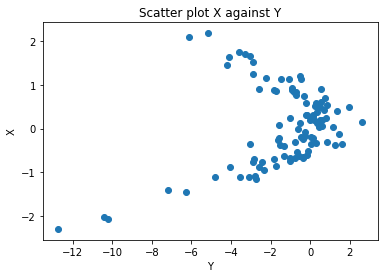

In [13]:
plt.scatter(y, x) # questions wants X against Y i.e. X on the y-axis
plt.title('Scatter plot X against Y') 
plt.xlabel('Y')
plt.ylabel('X')
plt.show()

The graph looks quadratic, with Y maximum near X = 0

## Part c

Set a random seed, and then compute the Leave-One-Out Cross-Validation (LOOCV) errors that result from fitting the following four models using least squares:
         
i. $Y = \beta_0 + \beta_1 X + \epsilon$

ii. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon$

iii. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$ 

iv. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \epsilon$ 

Note: for linear regression, the LOOCV error can be computed via the following short-cut formula:

$$  \text{LOOCV Error} = \frac{1}{n}\sum_{i=1}^{n} \bigg( \frac{Y_i - \widehat{Y_i}}{1-H_{ii}} \bigg)^2$$

where $H_{ii}$ is the $i^\text{th}$ diagonal entry of the projection matrix $H = \textbf{X}(\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T$, and $\textbf{X}$ is a matrix of predictors (the design matrix). This formula is an alternative to actually carrying out the $n = 100$ regressions you would otherwise need for LOOCV. An example of how to calculate the projection matrix $H$ is provided below for the case of $n=5$ and the model $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon$ . To get the diagonal elements of $H$ you may find the function `np.diag()` useful.

In [16]:
example_x = np.array([-3, -4, -5, -6, -7])        #generate the x variable
design_x = np.vander(example_x, 3)          #calculate the design matrix for the polynomial model with 3 fit parameters
H = np.dot(design_x, np.dot(np.linalg.inv(np.dot(design_x.T, design_x)), design_x.T))  #calculate H

In [ ]:
## please put your answer here ##

## Part d

Repeat Part c using another random seed to generate data, and report your results. Are your results the same as what you got in Part c? Why?

In [18]:
## please put your answer here ##

## Part e

Which of the models in Part c had the smallest LOOCV error? Is this what you expected? Explain your answer.

In [19]:
## please put your answer here ##

## Part f

Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in Part c using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

In [20]:
## please put your answer here ##